In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd
import glob
import os

In [6]:
df=pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/co_data/merged_file.csv')


In [11]:
type(df)


pandas.core.frame.DataFrame

In [ ]:
type(df['Date'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')



In [15]:
df['Year'] = df['Date'].dt.year
df['Month_Year'] = df['Date'].dt.to_period('M')

In [16]:
df_cook = df[df['County'] == "Cook"]

In [19]:
# Extract unique site names with their latitude and longitude
site_coords = df_cook[['Local Site Name', 'Site Latitude', 'Site Longitude']].drop_duplicates()

# Merge the monthly data with the site coordinates
df_cook_monthly = df_cook.groupby(['Local Site Name', 'Month_Year'])['Daily AQI Value'].mean().reset_index()
df_cook_monthly.rename(columns={'Daily AQI Value': 'monthly_value'}, inplace=True)
df_cook_monthly = df_cook_monthly.merge(site_coords, on='Local Site Name', how='left')

In [95]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import TimestampedGeoJson

import matplotlib.pyplot as plt
import branca.colormap as cm

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    return df, df_county, df_county_monthly, site_coords

def create_time_series_map(df_county_monthly, latitude_column, longitude_column, site_name_column, value_column, month_year_column):
    # Prepare the data for the time series map
    features = []
    for _, row in df_county_monthly.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row[longitude_column], row[latitude_column]],
            },
            'properties': {
                'time': str(row[month_year_column]),
                'popup': f"Site: {row[site_name_column]}<br>Monthly Value: {row[value_column]:.2f}",
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.6,
                    'stroke': 'true',
                    'radius': 8
                }
            }
        }
        features.append(feature)

    # Create a GeoJSON object
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }

    # Create the folium map
    m = folium.Map(location=[df_county_monthly[latitude_column].mean(), df_county_monthly[longitude_column].mean()], zoom_start=10, tiles='CartoDB positron')

    # Add the time series layer
    TimestampedGeoJson(
        geojson,
        transition_time=200,
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM',
        time_slider_drag_update=True
    ).add_to(m)

    # Add a title
    title_html = '''
        <h3 align="center" style="font-size:16px"><b>Time Series of CO Concentration</b></h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    return m

def plot_time_series(df_county_monthly, month_year_column, value_column, site_name_column):
    # Create a line plot for each site
    plt.figure(figsize=(14, 8))
    df_county_monthly[month_year_column] = df_county_monthly[month_year_column].astype(str)
    sns.lineplot(data=df_county_monthly, x=month_year_column, y=value_column, hue=site_name_column, marker='o')

    # Customize the plot
    plt.title("Time Series of CO Concentration by Site", fontsize=16)
    plt.xlabel("Month-Year", fontsize=12)
    plt.ylabel("Monthly Average CO Concentration", fontsize=12)
    plt.xticks(rotation=90)
    plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, value_column):
    # Create a GeoDataFrame from the monthly data
    geometry = [Point(xy) for xy in zip(df_county_monthly[longitude_column], df_county_monthly[latitude_column])]
    gdf = gpd.GeoDataFrame(df_county_monthly, geometry=geometry)

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, column=value_column, cmap='coolwarm', legend=True, markersize=50)

    # Customize the plot
    plt.title("Monthly Average CO Concentration (Sites)", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

In [20]:
!pip install geopandas
!pip install folium


  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyproj-3.7.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (31 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 8.7 MB/s eta 0:00:0000:0100:01
Using cached pyproj-3.7.1-cp313-cp313-macosx_14_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00a 0:00:01
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [geopandas]/5 [geopandas]
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2

In [31]:
import folium
from folium.plugins import TimestampedGeoJson
import json

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red',
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 8
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import json
import branca.colormap as cm

# Create a linear colormap from green (low values) to red (high values)
min_val = df_cook_monthly['monthly_value'].min()
max_val = df_cook_monthly['monthly_value'].max()
colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)  # You can change to e.g. 'Viridis_09' or 'RdYlGn_09'

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    color = colormap(row['monthly_value'])  # Get color from the colormap
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,
                'fillOpacity': 0.6,
                'stroke': True,
                'radius': 8,
                'color': 'black',
                'weight': 1
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add colormap to the map
colormap.caption = 'Monthly CO Value'
colormap.add_to(m)

# Display the map
m


In [36]:
m.save('chicago_co_time_series_map.html')


In [38]:
# Define the bounding box for Chicago (approximate boundaries)
chicago_bounds = [[41.6445, -87.9401], [42.0230, -87.5237]]  # [southwest, northeast]

# Set the map's bounds to Chicago
m.fit_bounds(chicago_bounds)

# Display the updated map
m

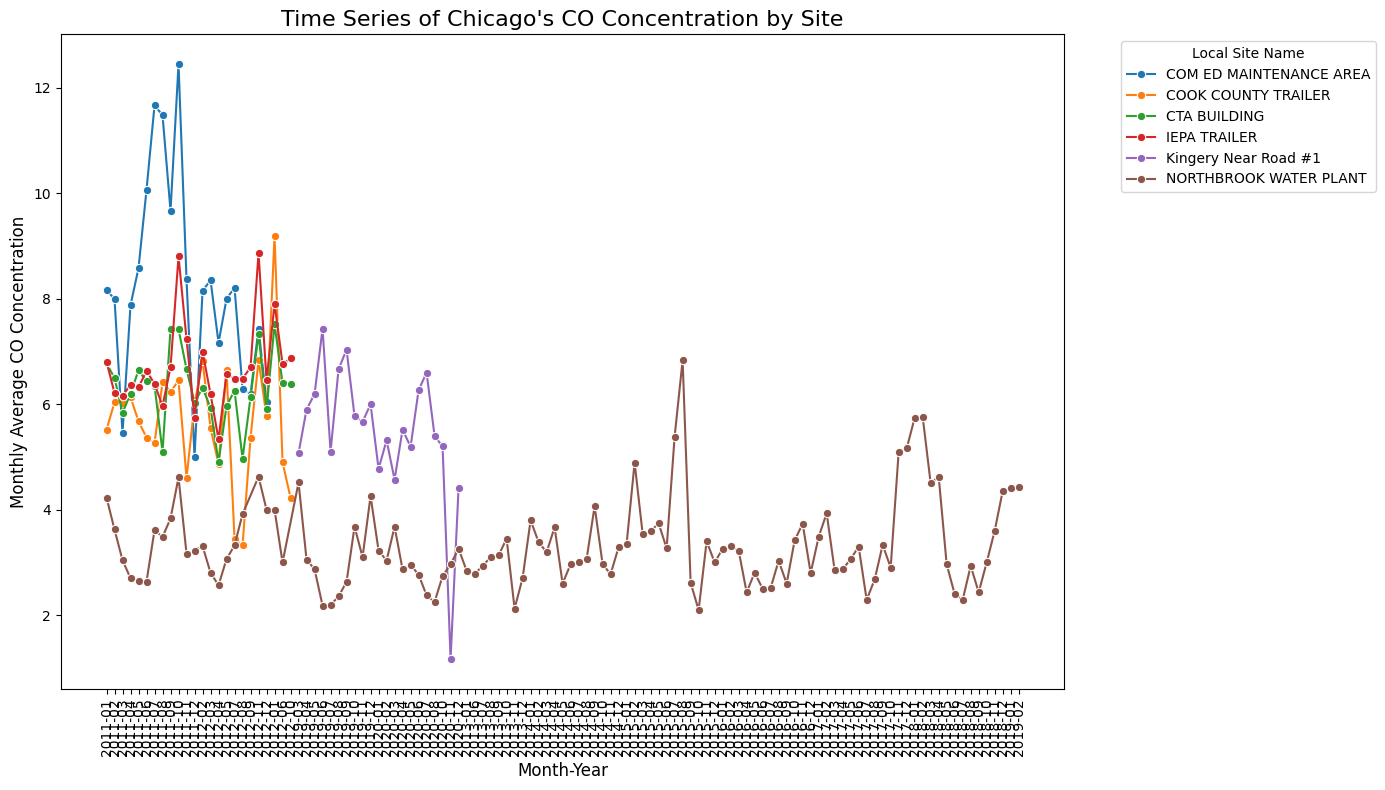

In [94]:
import matplotlib.pyplot as plt
# Create a line plot for each site
plt.figure(figsize=(14, 8))
# Convert 'Month_Year' to string for plotting
df_cook_monthly['Month_Year'] = df_cook_monthly['Month_Year'].astype(str)
sns.lineplot(data=df_cook_monthly, x='Month_Year', y='monthly_value', hue='Local Site Name', marker='o')

# Customize the plot
plt.title("Time Series of Chicago's CO Concentration by Site", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Monthly Average CO Concentration", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

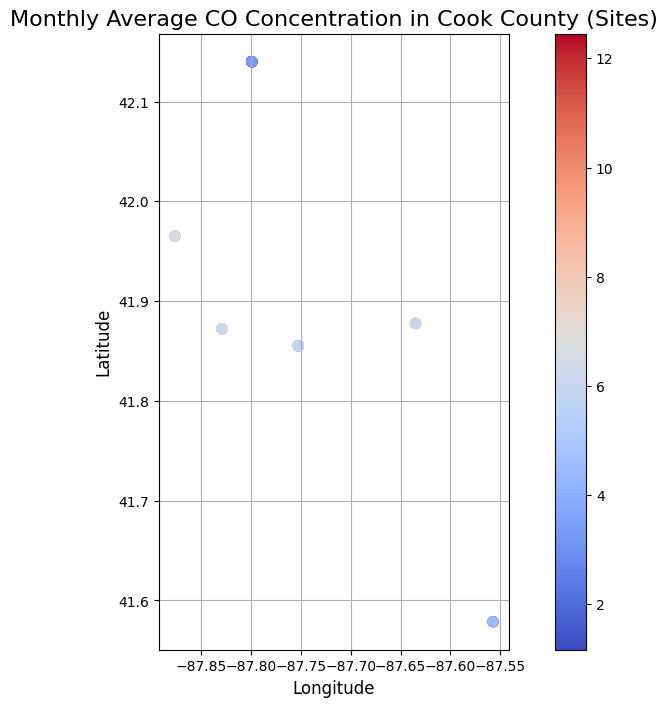

In [26]:
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

# Create a GeoDataFrame from df_cook_monthly
geometry = [Point(xy) for xy in zip(df_cook_monthly['Site Longitude'], df_cook_monthly['Site Latitude'])]
gdf = gpd.GeoDataFrame(df_cook_monthly, geometry=geometry)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='monthly_value', cmap='coolwarm', legend=True, markersize=50)

# Customize the plot
plt.title("Monthly Average CO Concentration in Cook County (Sites)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [93]:
import folium
from folium.plugins import TimestampedGeoJson
import json

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red',
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 8
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m




In [14]:
type(df['Date'])


pandas.core.series.Series

In [ ]:
import seaborn as sns

# Display basic information about the DataFrame
print("Basic Information:")
print(df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df.head())

# Check the distribution of the 'Daily Max 8-hour CO Concentration'
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Daily Max 8-hour CO Concentration'], kde=True, bins=30)
plt.title('Distribution of Daily Max 8-hour CO Concentration')
plt.xlabel('CO Concentration')
plt.ylabel('Frequency')
plt.show()

# Check the correlation between numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Count the number of unique values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")
    

## dynamic processing

In [110]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import TimestampedGeoJson

import matplotlib.pyplot as plt
import branca.colormap as cm

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    return df, df_county, df_county_monthly, site_coords

def create_time_series_map(df_county_monthly, latitude_column, longitude_column, site_name_column, value_column, month_year_column, title=None):
    # Create a color map based on the value range
    min_val = df_county_monthly[value_column].min()
    max_val = df_county_monthly[value_column].max()
    colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
    colormap.caption = 'Monthly Average Concentration'

    # Prepare the data for the time series map
    features = []
    for _, row in df_county_monthly.iterrows():
        color = colormap(row[value_column])  # Get color from colormap
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row[longitude_column], row[latitude_column]],
            },
            'properties': {
                'time': str(row[month_year_column]),
                'popup': f"Site: {row[site_name_column]}<br>Monthly Value: {row[value_column]:.2f}",
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': color,
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 8,
                    'color': 'black',
                    'weight': 1
                }
            }
        }
        features.append(feature)

    # Create a GeoJSON object
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }

    # Create the folium map
    m = folium.Map(location=[df_county_monthly[latitude_column].mean(), df_county_monthly[longitude_column].mean()],
                   zoom_start=10, tiles='CartoDB positron')

    # Add time series GeoJSON layer
    TimestampedGeoJson(
        geojson,
        transition_time=200,
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM',
        time_slider_drag_update=True
    ).add_to(m)

    # Add colormap to the map
    colormap.add_to(m)

    # Add a title
    if title:
        title_html = f'''
            <h3 align="center" style="font-size:16px"><b>{title}</b></h3>
        '''
        m.get_root().html.add_child(folium.Element(title_html))

    return m

def plot_time_series(df_county_monthly, month_year_column, value_column, site_name_column):
    # Create a line plot for each site
    plt.figure(figsize=(14, 8))
    df_county_monthly[month_year_column] = df_county_monthly[month_year_column].astype(str)
    sns.lineplot(data=df_county_monthly, x=month_year_column, y=value_column, hue=site_name_column, marker='o')

    # Customize the plot
    plt.title("Time Series of CO Concentration by Site", fontsize=16)
    plt.xlabel("Month-Year", fontsize=12)
    plt.ylabel("Monthly Average CO Concentration", fontsize=12)
    plt.xticks(rotation=90)
    plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, value_column):
    # Create a GeoDataFrame from the monthly data
    geometry = [Point(xy) for xy in zip(df_county_monthly[longitude_column], df_county_monthly[latitude_column])]
    gdf = gpd.GeoDataFrame(df_county_monthly, geometry=geometry)

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, column=value_column, cmap='coolwarm', legend=True, markersize=50)

    # Customize the plot
    plt.title("Monthly Average NO2 Concentration (Sites)", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

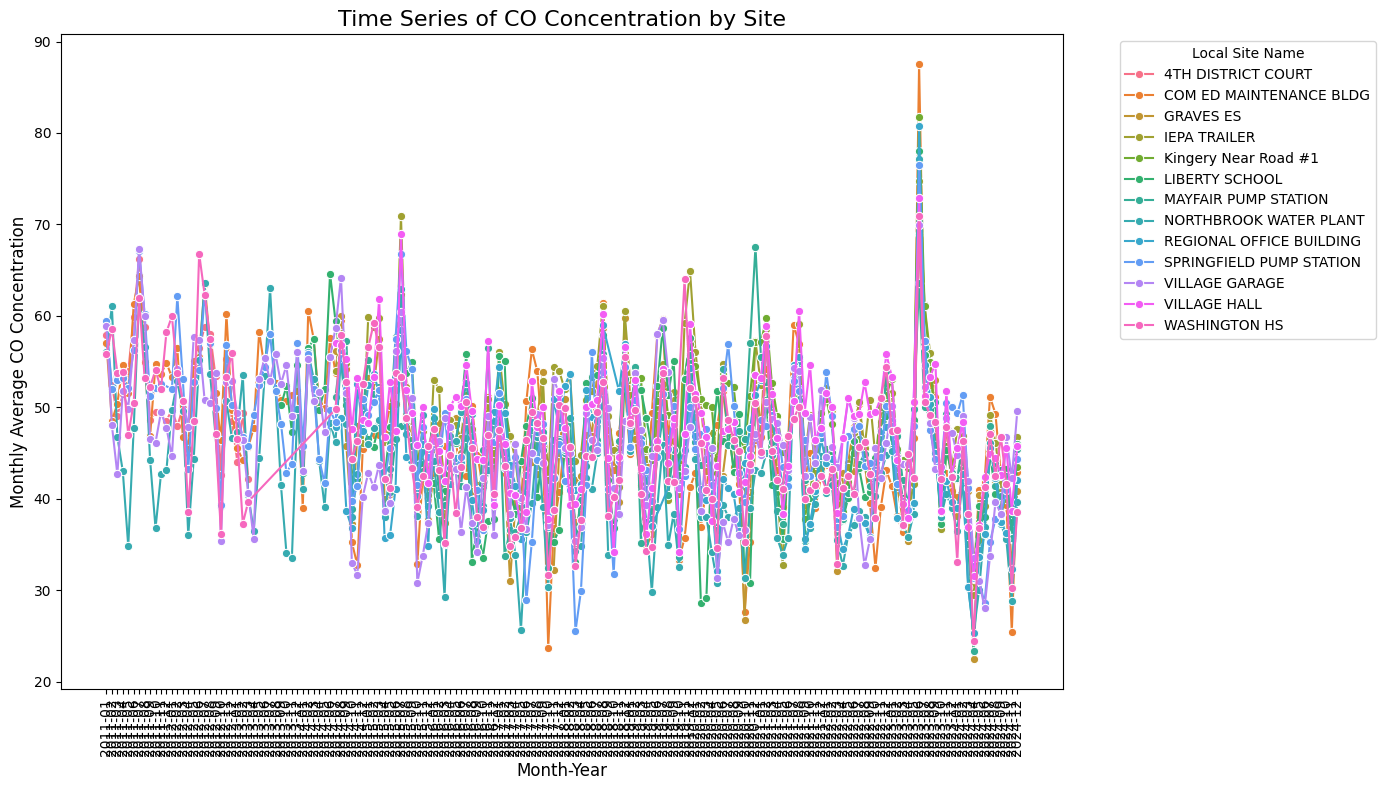

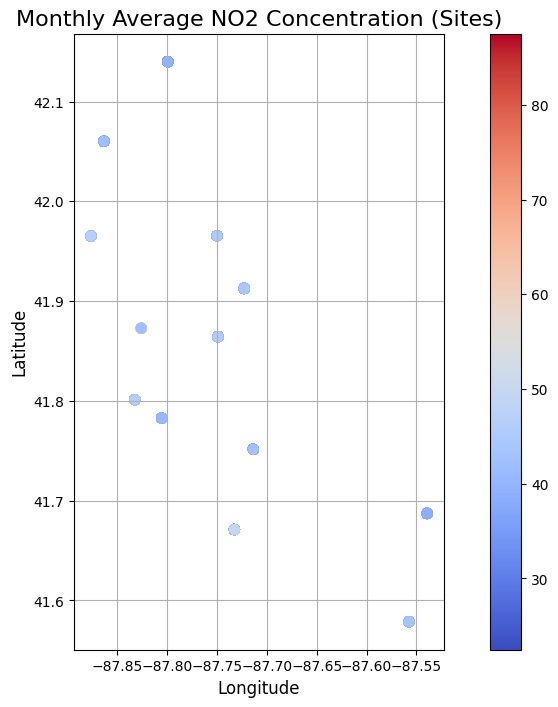

In [119]:
# Example usage of process_dataset function
file_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/merged_2.5.csv'
county_name = "Cook"
pollutant_column = 'Daily AQI Value'
date_column = 'Date'
site_name_column = 'Local Site Name'
latitude_column = 'Site Latitude'
longitude_column = 'Site Longitude'

df, df_county, df_county_monthly, site_coords = process_dataset(
    file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column
)

# Example usage of create_time_series_map function
time_series_map = create_time_series_map(
    df_county_monthly, latitude_column, longitude_column, site_name_column, 'monthly_value', 'Month_Year'
)
time_series_map.save('time_series_pm2.5.html')  # Save the map to an HTML file

# Example usage of plot_time_series function
plot_time_series(df_county_monthly, 'Month_Year', 'monthly_value', site_name_column)

# Example usage of plot_geospatial_distribution function
plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, 'monthly_value')

In [ ]:
import os

# Define folder path and parameters
folder_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
county_name = "Cook"
pollutant_column = 'Daily AQI Value'  # Update this if different pollutants exist
date_column = 'Date'
site_name_column = 'Local Site Name'
latitude_column = 'Site Latitude'
longitude_column = 'Site Longitude'

# Iterate through all CSV files in folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Process dataset
        df, df_county, df_county_monthly, site_coords = process_dataset(
            file_path, county_name, pollutant_column, date_column,
            site_name_column, latitude_column, longitude_column
        )
        
        # Create and save time series map
        time_series_map = create_time_series_map(
            df_county_monthly, latitude_column, longitude_column,
            site_name_column, 'monthly_value', 'Month_Year'
        )
        
        # Generate output filename
        html_filename = filename.replace('.csv', '.html')
        time_series_map.save(html_filename)
        
        # Generate plots
        plot_time_series(df_county_monthly, 'Month_Year', 'monthly_value', site_name_column)
        plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, 'monthly_value')


KeyError: 'Date'

## working on the model


In [65]:
import folium
from folium.plugins import HeatMap

# Assume map_df is your DataFrame loaded as shown above
map_df= pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/chicago_data.csv')

map_center = [map_df['Latitude'].mean(), map_df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')

for _, row in map_df.iterrows():
    popup_text = f"Name: {row['Name']}<br>Population: {row['Population']}<br>PMC 2020: {row['PMC_2020']:.2f}"
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Heatmap weighted by population
heat_data = [[row['Latitude'], row['Longitude'], row['PMC_2020']*row['Population']] for _, row in map_df.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)

m

In [66]:
pmc_columns = [col for col in map_df.columns if col.startswith('PMC_')]

# Melt to long format
map_df_long = map_df.melt(
    id_vars=['Layer', 'Name', 'GEOID', 'Population', 'Longitude', 'Latitude'],
    value_vars=pmc_columns,
    var_name='Year',
    value_name='PMC'
)

# Extract just the year as integer
map_df_long['Year'] = map_df_long['Year'].str.replace('PMC_', '').astype(int)

In [71]:
import folium
from folium.plugins import TimestampedGeoJson
import branca.colormap as cm
import numpy as np
import pandas as pd

# First, clean any potential NaN values
map_df_long = map_df_long.dropna(subset=['PMC'])

# Get valid min and max values, ensuring they're different
min_pmc = map_df_long['PMC'].min()
max_pmc = map_df_long['PMC'].max()

# If min and max are too close, add a small buffer
if abs(max_pmc - min_pmc) < 0.001:
    max_pmc += 0.001

# Create colormap with explicit steps to avoid sorting issues
colormap = cm.LinearColormap(
    colors=['yellow', 'orange', 'red'],
    vmin=min_pmc,
    vmax=max_pmc
)

# Function to get color safely
def get_color(pmc_value):
    if pd.isna(pmc_value):
        return '#CCCCCC'  # Gray for NaN values
    try:
        return colormap(pmc_value)
    except ValueError:
        # Fallback if value is outside the range
        if pmc_value < min_pmc:
            return colormap(min_pmc)
        else:
            return colormap(max_pmc)

# Create features for each row in map_df_long
features = []
for _, row in map_df_long.iterrows():
    color = get_color(row['PMC'])
    
    # Scale marker size based on population (optional)
    radius = 6 + np.log(row['Population']) / 2  # Adjust scaling as needed
    
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Longitude'], row['Latitude']],
        },
        'properties': {
            'time': str(row['Year']),
            'popup': f"<b>{row['Name']}</b><br>Population: {row['Population']}<br>PMC ({row['Year']}): {row['PMC']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,
                'fillOpacity': 0.7,
                'stroke': 'true',
                'radius': radius,
                'color': 'black',
                'weight': 1
            }
        }
    }
    features.append(feature)

# Create GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map centered on the average coordinates
m = folium.Map(
    location=[map_df_long['Latitude'].mean(), map_df_long['Longitude'].mean()], 
    zoom_start=12, 
    tiles='CartoDB positron'
)

# Add time series GeoJSON layer
TimestampedGeoJson(
    geojson,
    transition_time=300,
    period='P1Y',  # yearly period
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY',
    time_slider_drag_update=True
).add_to(m)

# Add the colormap to the map
colormap.caption = 'PMC Value'
colormap.add_to(m)

# Add a title to the map
title_html = '''
    <h3 align="center" style="font-size:16px">Census Tract PMC Values Over Time (2011-2020)</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file
m.save('census_tracts_pmc_time_series.html')


/var/folders/9c/cqhq_9tn7xg260y42gb15wym0000gn/T/ipykernel_11659/3520456569.py:44: RuntimeWarning: divide by zero encountered in log
  radius = 6 + np.log(row['Population']) / 2  # Adjust scaling as needed


In [70]:
type(map_df_long['PMC'])

pandas.core.series.Series

In [72]:
merged_co=pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/merged_co.csv')
merged_co.head()


,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,01/01/2011,AQS,170310063,1,0.4,ppm,5,CTA BUILDING,19,79.0,...,Carbon monoxide,54.0,16980,"Chicago-Naperville-Elgin, IL-IN-WI",17,Illinois,31,Cook,41.877682,-87.635027
1,01/01/2011,AQS,170313103,1,0.5,ppm,6,IEPA TRAILER,19,79.0,...,Carbon monoxide,54.0,16980,"Chicago-Naperville-Elgin, IL-IN-WI",17,Illinois,31,Cook,41.965193,-87.876265
2,01/01/2011,AQS,170314002,1,0.2,ppm,2,COOK COUNTY TRAILER,19,79.0,...,Carbon monoxide,93.0,16980,"Chicago-Naperville-Elgin, IL-IN-WI",17,Illinois,31,Cook,41.855243,-87.752470
3,01/01/2011,AQS,170314201,1,0.2,ppm,2,NORTHBROOK WATER PLANT,19,79.0,...,Carbon monoxide,554.0,16980,"Chicago-Naperville-Elgin, IL-IN-WI",17,Illinois,31,Cook,42.139996,-87.799227
4,01/01/2011,AQS,170316004,1,0.3,ppm,3,COM ED MAINTENANCE AREA,19,79.0,...,Carbon monoxide,93.0,16980,"Chicago-Naperville-Elgin, IL-IN-WI",17,Illinois,31,Cook,41.872117,-87.829080


In [74]:
merged_co.columns


Index(['Date', 'Source', 'Site ID', 'POC', 'Daily Max 8-hour CO Concentration',
       'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count',
       'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description',
       'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State',
       'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude'],
      dtype='object')

In [ ]:
import pandas as pd
import os
from pathlib import Path

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None, None, None
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Check if any data for this county
    if len(df_county) == 0:
        print(f"No data found for county '{county_name}' in {os.path.basename(file_path)}")
        return df, None, None, None
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    # Add pollutant type identifier (derived from filename)
    pollutant_type = os.path.basename(file_path).split('_')[1].split('.')[0].upper()
    df_county_monthly['pollutant_type'] = pollutant_type
    
    return df, df_county, df_county_monthly, site_coords

# Define base folder path (check if this folder exists)
base_folder = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
if not os.path.exists(base_folder):
    print(f"Warning: Base folder not found: {base_folder}")
    print("Please check if the path is correct")

# Define dataset parameters (same for all datasets based on your example)
common_params = {
    'county_name': 'Cook',
    'pollutant_column': 'Daily AQI Value',
    'date_column': 'Date',
    'site_name_column': 'Local Site Name',
    'latitude_column': 'Site Latitude', 
    'longitude_column': 'Site Longitude'
}

# List of datasets to process
datasets = ['merged_co', 'merged_no', 'merged_pm10', 'merged_so2', 'merged_2.5']


# Process each dataset and store results
results = {}
monthly_data_all = []

for dataset in datasets:
    file_path = os.path.join(base_folder, f"{dataset}.csv")
    print(f"Processing {dataset}...")
    
    df, df_county, df_county_monthly, site_coords = process_dataset(
        file_path,
        **common_params
    )
    
    if df is not None:
        results[dataset] = {
            'df': df,
            'df_county': df_county,
            'df_county_monthly': df_county_monthly,
            'site_coords': site_coords
        }
        
        if df_county_monthly is not None:
            monthly_data_all.append(df_county_monthly)

if monthly_data_all:
    combined_monthly_data = pd.concat(monthly_data_all, ignore_index=True)
    print(f"Combined data has {len(combined_monthly_data)} rows from {len(monthly_data_all)} datasets")
else:
    combined_monthly_data = None
    print("No monthly data was processed successfully")

for dataset, data in results.items():
    if data['df_county_monthly'] is not None:
        print(f"{dataset}: {len(data['df_county_monthly'])} monthly records for {data['df_county_monthly'][common_params['site_name_column']].nunique()} sites")


Processing merged_co...
Processing merged_no...
Processing merged_pm10...
Processing merged_so2...
Processing merged_2.5...
Combined data has 3243 rows from 5 datasets
merged_co: 227 monthly records for 6 sites
merged_no: 536 monthly records for 8 sites
merged_pm10: 326 monthly records for 3 sites
merged_so2: 476 monthly records for 3 sites
merged_2.5: 1678 monthly records for 13 sites


In [ ]:
import os
import pandas as pd

base_folder = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
datasets = ['merged_co', 'merged_no', 'merged_pm10', 'merged_so2', 'merged_2.5']

common_params = {
    'county_name': 'Cook',
    'pollutant_column': 'Daily AQI Value',
    'date_column': 'Date',
    'site_name_column': 'Local Site Name',
    'latitude_column': 'Site Latitude', 
    'longitude_column': 'Site Longitude'
}

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    df = pd.read_csv(file_path)
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    df_county = df[df['County'] == county_name]
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    return df, df_county, df_county_monthly, site_coords

all_dfs = {}

for dataset in datasets:
    file_path = os.path.join(base_folder, f"{dataset}.csv")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        continue
    df, df_county, df_county_monthly, site_coords = process_dataset(
        file_path,
        **common_params
    )
    all_dfs[f'df_{dataset}'] = df
    all_dfs[f'df_county_{dataset}'] = df_county
    all_dfs[f'df_county_monthly_{dataset}'] = df_county_monthly
    all_dfs[f'site_coords_{dataset}'] = site_coords

for name, df in all_dfs.items():
    globals()[name] = df

# Print the names of the created dataframes
print(list(all_dfs.keys()))


['df_merged_co', 'df_county_merged_co', 'df_county_monthly_merged_co', 'site_coords_merged_co', 'df_merged_no', 'df_county_merged_no', 'df_county_monthly_merged_no', 'site_coords_merged_no', 'df_merged_pm10', 'df_county_merged_pm10', 'df_county_monthly_merged_pm10', 'site_coords_merged_pm10', 'df_merged_so2', 'df_county_merged_so2', 'df_county_monthly_merged_so2', 'site_coords_merged_so2', 'df_merged_2.5', 'df_county_merged_2.5', 'df_county_monthly_merged_2.5', 'site_coords_merged_2.5']


In [ ]:
import os

output_folder = 'monthly'
os.makedirs(output_folder, exist_ok=True)

for dataset in datasets:
    monthly_key = f'df_county_monthly_{dataset}'
    if monthly_key in globals():
        pollutant_name = dataset.replace('merged_', '')
        globals()[monthly_key]['pollutant'] = pollutant_name
        output_path = os.path.join(output_folder, f'{dataset}_monthly.csv')
        globals()[monthly_key].to_csv(output_path, index=False)
        print(f"Saved {dataset} monthly data with pollutant column to {output_path}")
    else:
        print(f"No monthly data found for {dataset}")


Saved merged_co monthly data with pollutant column to monthly/merged_co_monthly.csv
Saved merged_no monthly data with pollutant column to monthly/merged_no_monthly.csv
Saved merged_pm10 monthly data with pollutant column to monthly/merged_pm10_monthly.csv
Saved merged_so2 monthly data with pollutant column to monthly/merged_so2_monthly.csv
Saved merged_2.5 monthly data with pollutant column to monthly/merged_2.5_monthly.csv


## CONVLSTM

In [105]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.6.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-macosx_12_0_arm64.whl (11.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 16.1 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
data_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/monthly/'  # Replace with your actual path

pollutants = ['co', 'no', 'pm10', 'so2', '2.5']
dfs = []

for p in pollutants:
    df = pd.read_csv(f'{data_path}/merged_{p}_monthly.csv', parse_dates=['Month_Year'])
    df['pollutant'] = p.upper()  # Add pollutant type
    dfs.append(df)

combined_df = pd.concat(dfs, axis=0)


## Grid for Chicago

In [125]:
# Create grid for Chicago (example: 10x10 grid)
GRID_SIZE = 10
LAT_MIN, LAT_MAX = 41.6, 42.1
LON_MIN, LON_MAX = -87.9, -87.5

def assign_grid(row):
    lat_bin = int((row['Site Latitude'] - LAT_MIN) / (LAT_MAX - LAT_MIN) * GRID_SIZE)
    lon_bin = int((row['Site Longitude'] - LON_MIN) / (LON_MAX - LON_MIN) * GRID_SIZE)
    return f"{lat_bin}_{lon_bin}"

combined_df['grid_id'] = combined_df.apply(assign_grid, axis=1)


In [126]:
combined_df['grid_id'].head()

0    5_1
1    5_1
2    5_1
3    5_1
4    5_1
Name: grid_id, dtype: object

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load all pollutant datasets
pollutants = ['co', 'no', 'pm10', 'so2', '2.5']
dfs = []

for p in pollutants:
    df = pd.read_csv(f'merged_{p}.csv', parse_dates=['Date'])
    df['pollutant'] = p.upper()  # Add pollutant type
    dfs.append(df)

# Combine into single DataFrame
combined_df = pd.concat(dfs, axis=0)
